In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from lsst.all_sky_phot.wcs import Fisheye, load_fisheye
from lsst.all_sky_phot import extinction_map, readYBC, readcr2, lsst_earth_location, radec2altaz
import healpy as hp

import photutils as phu
import time

In [2]:
# Load up the WCS we fit in Full_WCS_fit
wcs = load_fisheye('fisheye_wcs.npz')

In [3]:
# Load the Yale Bright Star catalog
ybc = readYBC()

In [4]:
# Read in an image
filename = 'ut012716/ut012716.0130.long.cr2'
im, header = readcr2(filename)
# Combine the RGB into a single image
sum_image = np.sum(im, axis=2).astype(float)


In [10]:
# Compute the expected catalog alt and az

alt_cat, az_cat = radec2altaz(ybc['RA'], ybc['Dec'], header['mjd'])
above = np.where(alt_cat > 15.)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater


In [17]:
zp = 18.
t0 = time.time()
emap = extinction_map(sum_image, wcs, zp, alt_cat[above], az_cat[above], ybc['Vmag'].values[above])
t1 = time.time()
print 'runtime=%.1f s' % (t1-t0)

runtime=43.8 s


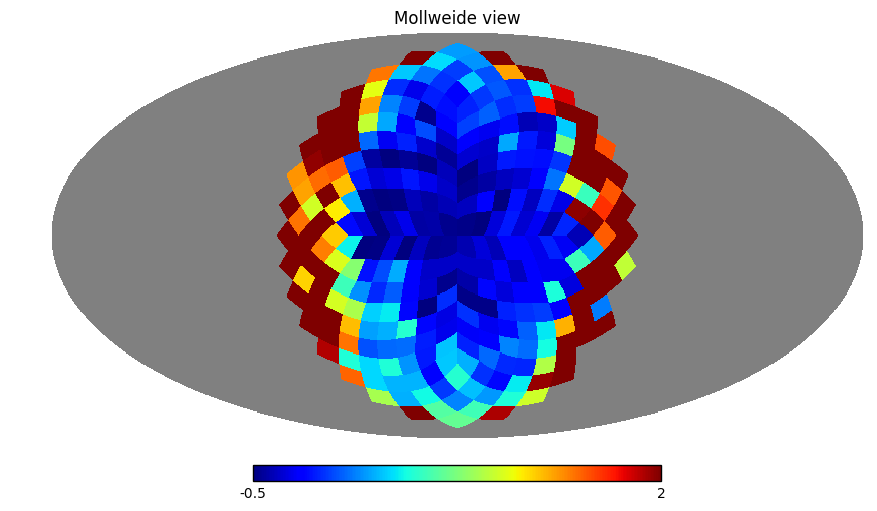

In [15]:
hp.mollview(emap, rot=[0,90,0], min=-.5, max=2)

In [8]:
# Let's look at how well we are doing with the wcs
catalog_x, catalog_y = wcs.all_world2pix(az_cat[above], alt_cat[above], 0)
good_transform = ~np.isnan(catalog_x)
positions = list(zip(catalog_x[good_transform], catalog_y[good_transform]))
apertures = phu.CircularAperture(positions, r=5.)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


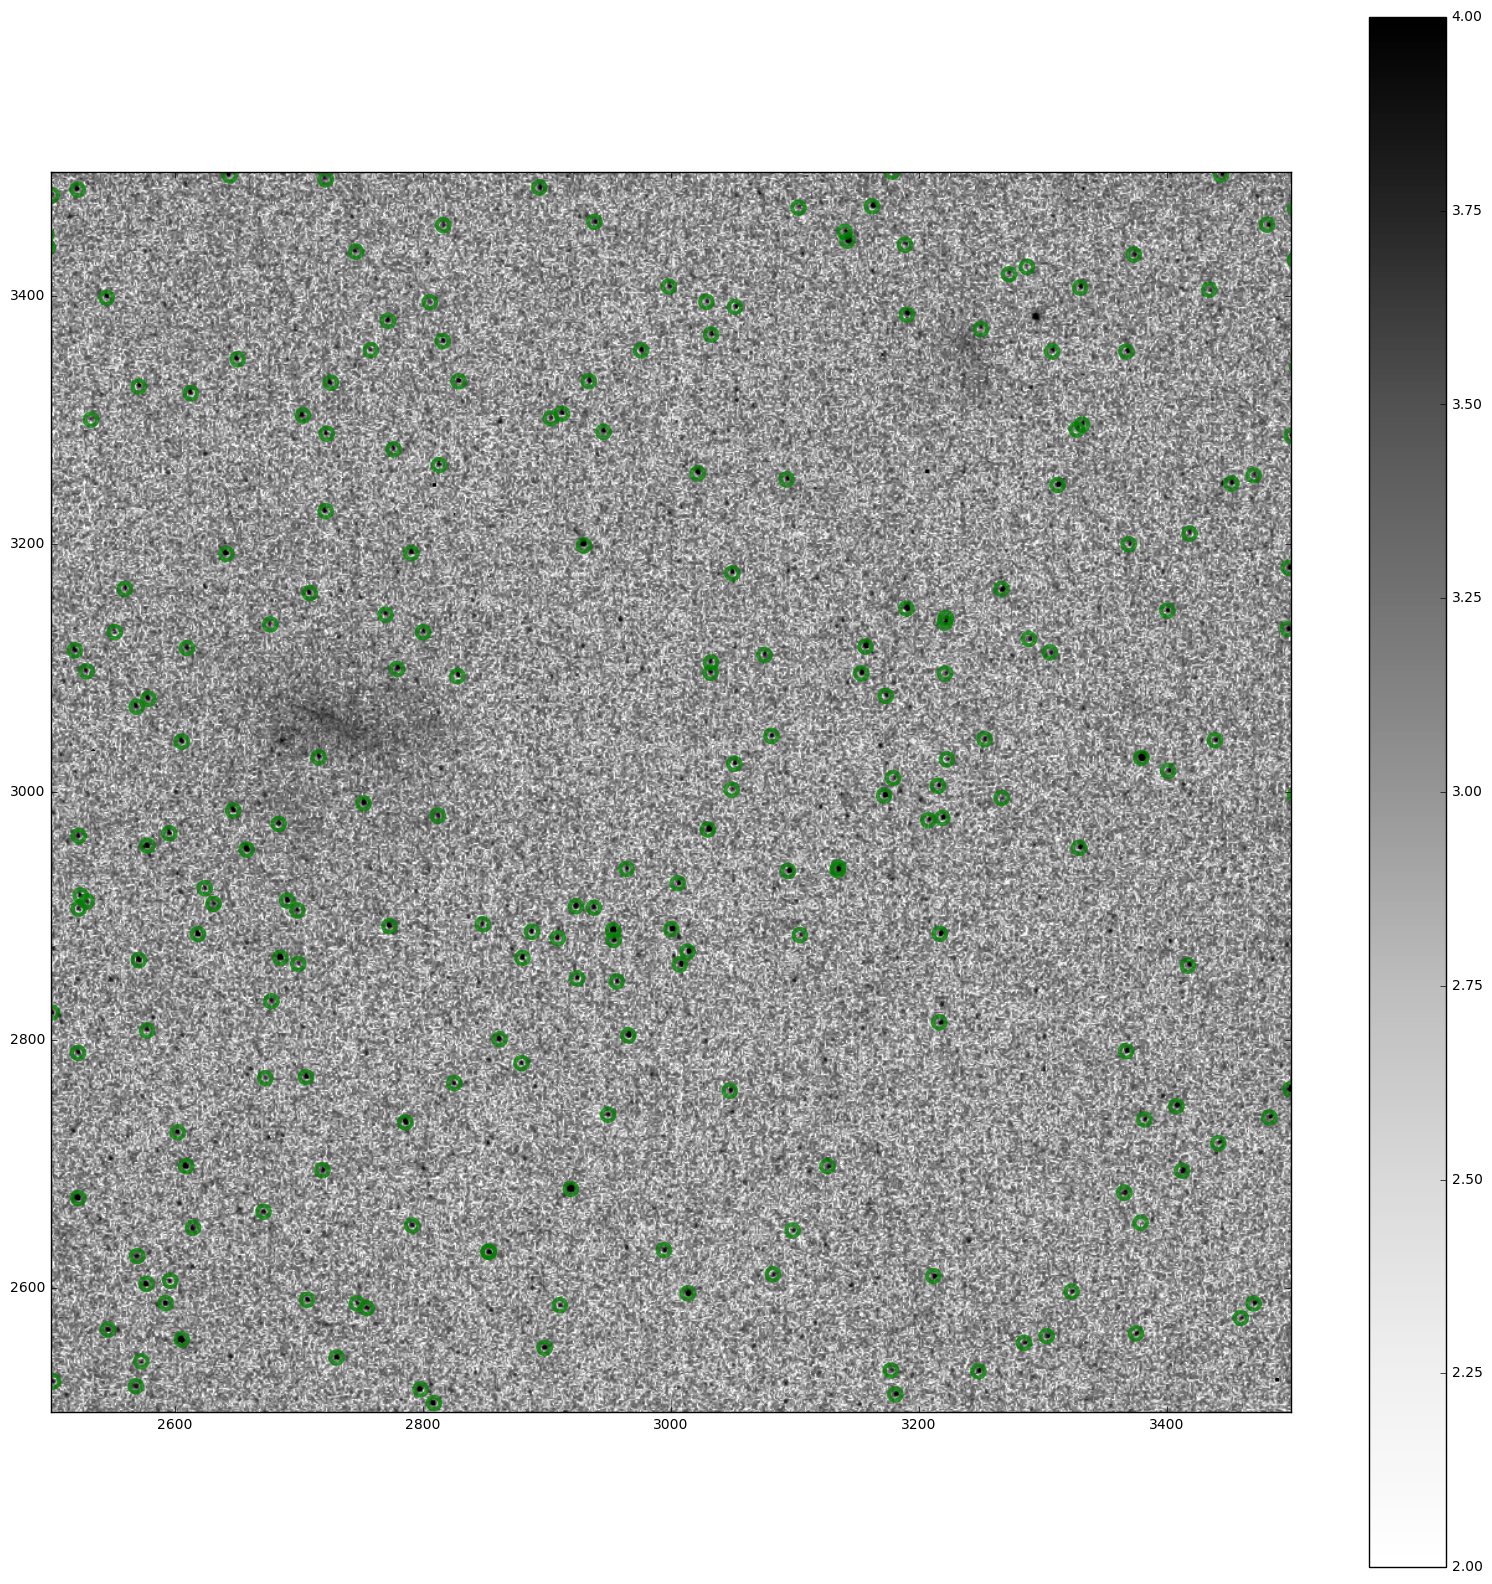

In [9]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(sum_image),  cmap='Greys', origin='lower', vmin=2, vmax=4)
plt.colorbar()
plt.xlim([2500,3500])
plt.ylim([2500,3500])
apertures.plot(color='green', lw=3, alpha=0.75)